In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-10-22 23:22:19.812735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 23:22:19.812774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 23:22:19.813319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 23:22:19.870957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-10-22 23:22:24.386941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 23:22:24.442751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 23:22:24.442903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Datos

In [3]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('../../../Datasets/Humedas_Secas_procesadas/Recortadas/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


In [4]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)
df_secas 

,routes,label
0,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
1,../../../Datasets/Humedas_Secas_procesadas/Rec...,2
2,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
3,../../../Datasets/Humedas_Secas_procesadas/Rec...,1
4,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
...,...,...
926,../../../Datasets/Humedas_Secas_procesadas/Rec...,2
927,../../../Datasets/Humedas_Secas_procesadas/Rec...,1
928,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
929,../../../Datasets/Humedas_Secas_procesadas/Rec...,1


In [5]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [6]:
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  print("Final shape: ", tensor.shape)
  return tensor

def create_dataset(file_names, labels):
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels))
  dataset.shuffle(buffer_size=16)
  dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
  
  return dataset

file_names = train_cu3['routes'].to_numpy()
labels = train_cu3['label'].to_numpy()
dataset = create_dataset(file_names, labels)

Final shape:  (128, 128, 1)


2023-10-22 23:22:25.382748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 23:22:25.382999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 23:22:25.383173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(3, 128, 128, 1)
(3,)
tf.Tensor([b'2' b'2' b'2'], shape=(3,), dtype=string)
14


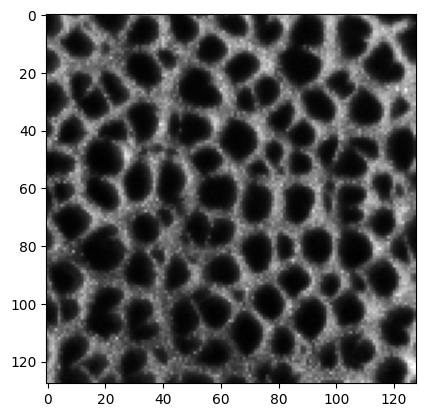

In [7]:
cnt = 0
for i in dataset.batch(16):
    cnt += 1
    a = i[0]
    b = i[1]


print(a.shape)
print(b.shape)
plt.imshow(a[0,:,:,0],cmap='gray')
print(b)
print(cnt)  

## Modelo

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction /= tf.reduce_max(reconstruction)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.reconstruction = reconstruction
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)       
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),            
        }

In [9]:
###_____________________________ENCODER________________________##
latent_dim = 32

nx, ny = 128, 128

encoder_inputs = keras.Input(shape=(nx, ny,1))

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E1')(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',name='layer_E3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name='layer_E4')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_E6')(x)
x = layers.Flatten()(x)



z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 layer_E1 (Conv2D)           (None, 128, 128, 1024)       10240     ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 1024)         0         ['layer_E1[0][0]']            
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 1024)         4096      ['max_pooling2d[0][0]'] 

In [10]:
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

##dimensiones
ndim = 16
nfilts = 128

## anti-flatten de la última capa convolucional
x = layers.Dense(ndim * ndim * nfilts, activation="relu")(latent_inputs)

## Reshape para reconstruir la última convolucional
x = layers.Reshape((ndim,ndim, nfilts))(x)

## Capas convolucionales
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_D1')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_D2')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_D4')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_D6')(x)

decoder_outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='layer_D7')(x)

## Construcción del decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 layer_D1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                          

In [11]:
vae = VAE(encoder, decoder)
opt = tf.optimizers.Adam(learning_rate = 0.000001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(dataset.batch(16), epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])

Epoch 1/2000


2023-10-22 23:22:30.123965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-22 23:22:33.788126: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f08ee1c5f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 23:22:33.788153: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-10-22 23:22:33.792903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 23:22:33.874344: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-10-22 23:22:36.625070: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate 

14/14 [==============================] - 19s 261ms/step - loss: 46649.8401 - reconstruction_loss: 46983.2500 - kl_loss: 0.0036
Epoch 2/2000
14/14 [==============================] - 2s 114ms/step - loss: 46474.9521 - reconstruction_loss: 46568.7578 - kl_loss: 0.0036
Epoch 3/2000
14/14 [==============================] - 2s 115ms/step - loss: 45509.5945 - reconstruction_loss: 46325.8711 - kl_loss: 0.0035
Epoch 4/2000
14/14 [==============================] - 2s 113ms/step - loss: 45400.5924 - reconstruction_loss: 46032.7500 - kl_loss: 0.0036
Epoch 5/2000
14/14 [==============================] - 2s 115ms/step - loss: 45487.8117 - reconstruction_loss: 46493.8086 - kl_loss: 0.0037
Epoch 6/2000
14/14 [==============================] - 2s 115ms/step - loss: 45600.8940 - reconstruction_loss: 46089.4766 - kl_loss: 0.0039
Epoch 7/2000
14/14 [==============================] - 2s 115ms/step - loss: 45578.7982 - reconstruction_loss: 45996.8984 - kl_loss: 0.0042
Epoch 8/2000
14/14 [===================

In [12]:
### Guardar modelohttps://www.tensorflow.org/guide/saved_model?hl=es-419
vae.encoder.save('Models/GVAE_MF3_encoder_DRY_2_32.h5')
vae.decoder.save('Models/GVAE_MF3_decoder_DRY_2_32.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
